In [25]:
!pip install ax-platform textblob

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import re
import string
from textblob import Word
import nltk

import itertools
from collections import defaultdict

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from ax.api.client import Client
from ax.api.configs import ChoiceParameterConfig, RangeParameterConfig

In [27]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [29]:
data = pd.read_csv('/content/drive/MyDrive/Colab Data/CSC705_Project/AVC_claims_survey.sql.csv', dtype={'comments': str})

In [30]:
# Randomly reorder the DataFrame
data = data.sample(frac=1).reset_index(drop=True)
satisfied = data['satisfied']


# Convert the pandas Series y to a torch LongTensor
y_tensor = torch.tensor(satisfied.values, dtype=torch.long)

# Perform one-hot encoding. Since labels are 1-5, we need 6 classes (0-5) to accommodate.
# Then, we'll remove the first column (index 0) which corresponds to a non-existent class.
satisfied_oh = F.one_hot(y_tensor, num_classes=6)[:, 1:]

In [31]:
neg_labels = satisfied_oh[:, 0] + satisfied_oh[:, 1]
neu_labels = satisfied_oh[:, 2]
pos_labels = satisfied_oh[:, 3] + satisfied_oh[:, 4]

satisfied_3labels = torch.stack([neg_labels, neu_labels, pos_labels], dim=1)

print(f"Original satisfied_oh shape: {satisfied_oh.shape}")
print(f"New satisfied_3labels shape: {satisfied_3labels.shape}")

Original satisfied_oh shape: torch.Size([10699, 5])
New satisfied_3labels shape: torch.Size([10699, 3])


In [32]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
data['comments'] = data['comments'].astype(str).fillna('')
# Split on any character that is NOT a word character (alphanumeric) or is an underscore.
# This effectively isolates all punctuation and symbols.
pattern = r'(\W|_)'
comments = [re.split(pattern, text.lower()) for text in data['comments']]
comments = [
    [item.strip() for item in sublist if item.strip()]
    for sublist in comments
]
comments = [
    [Word(item).lemmatize() for item in sublist]
    for sublist in comments
]

In [34]:
# Display unique tokens to verify separation
all_words = sorted(set(list(itertools.chain.from_iterable(comments))))

In [35]:
vocab = {i:t for i, t in enumerate(all_words)}
lookup = {token:integer for integer,token in vocab.items()}

In [36]:
encoded = [
    [lookup[token] for token in comment]
    for comment in comments
]
print([e[:5] for e in encoded])

[[1273, 5553, 5279, 1195, 5991], [2710, 11444, 7545, 10645, 5991], [5553, 11744, 4668, 800, 7065], [10645, 8342, 4792, 10143, 10785], [5997, 5983, 11358, 3549, 10785], [5553, 2235, 8413, 1247, 10645], [9382, 11444, 4998, 10785, 2222], [7327, 1031, 7, 6747, 8], [7327, 1031, 1205, 9382, 1952], [7327, 7697, 8333, 11691, 7327], [5553, 11444, 4381, 8140, 11691], [1602, 6097], [1249, 7449, 10785, 10645, 6392], [5553, 3755, 6, 10473, 6281], [7770, 2522, 951, 11, 3217], [10664, 9585, 10785, 1706, 7164], [10691, 10423, 5983, 5234, 4668], [7290, 5489, 1205, 7331, 1952], [5079, 9648], [9979, 11, 10645, 8941, 2251], [6601, 6505, 11444, 4381, 5346], [5553, 5279, 7545, 5161, 10645], [800, 11856, 2219, 9577, 11], [7545, 4218, 5983, 9662, 11844], [4256, 9648, 0], [1011, 10645, 1326, 11, 5553], [7327, 2251, 5983, 1600, 1205], [10691, 857, 5219, 10645, 1757], [5281, 6, 10473, 5161, 10754], [10691, 7265, 8689, 8333, 11444], [5553, 5161, 2193, 8807, 199], [4256, 9068, 13, 5553, 3530], [5553, 3755, 6, 1047

In [37]:
encoded = [torch.LongTensor(e) for e in encoded]

In [38]:
from sklearn.model_selection import train_test_split

# Split the encoded comments and satisfied_oh labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    encoded, satisfied_oh, test_size=0.2, random_state=42
)

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    encoded, satisfied_3labels, test_size=0.2, random_state=42
)

print(f"Training comments size: {len(X_train)}")
print(f"Testing comments size: {len(X_test)}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training comments size: 8559
Testing comments size: 2140
Training labels shape: torch.Size([8559, 5])
Testing labels shape: torch.Size([2140, 5])


In [39]:
class TextDataset(Dataset):
    def __init__(self, encoded_texts, labels):
        # Use clone().detach() to avoid UserWarning when creating tensor from tensor
        self.encodings = [seq.clone().detach().to(dtype=torch.long) for seq in encoded_texts]
        self.labels = labels.clone().detach().to(dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.encodings[idx], self.labels[idx]

In [40]:
def collate_batch(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded_texts, torch.stack(labels)

In [41]:
class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, num_classes, max_len=512, dropout=0.1):
        super(SentimentTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # Simple learnable positional encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, max_len, embed_dim))

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # x shape: (batch_size, seq_len)
        seq_len = x.size(1)

        x = self.embedding(x) + self.pos_encoder[:, :seq_len, :]
        x = self.dropout(x)

        x = self.transformer_encoder(x, src_key_padding_mask=mask)

        x = x.mean(dim=1)

        # Final classification layer
        logits = self.fc(x)
        return logits

In [42]:
#Ax configuration
client = Client()
parameters = [
    RangeParameterConfig(
        name="num_layers", parameter_type="int", bounds=(1, 5)
    ),
    ChoiceParameterConfig(
        name="learning_rate",
        parameter_type="float",
        values=(0.0001, 0.001, 0.01),
        is_ordered=True
    ),

    ChoiceParameterConfig(
        name="num_heads", parameter_type="int", values=(2, 4, 8, 16),
        is_ordered=True
    )
]

client.configure_experiment(parameters=parameters)

metric_name = "loss"
client.configure_optimization(objective=f"-{metric_name}")

In [43]:
embedding_dim = 64
num_layers = 1
output_size = 5
vocabulary_size = len(vocab)
learning_rate = 0.01

losses = defaultdict(list)

for i in range(10):
    trials = client.get_next_trials(max_trials=3)

    for trial_index, parameters in trials.items():
        # Note: hidden_size from parameters is currently ignored to ensure compatibility
        # with num_heads choices. We use fixed embedding_dim=64.
        # hidden_size = parameters["hidden_size"]
        num_layers = parameters["num_layers"]
        learning_rate = parameters["learning_rate"]
        num_heads = parameters["num_heads"]

        print("Hyperparameters: ", num_layers, learning_rate, num_heads)

        dataset = TextDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

        model = SentimentTransformer(len(vocab), embedding_dim, num_heads, num_layers, output_size).to(device)
        # Use BCEWithLogitsLoss to handle raw logits from the model
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        num_epochs = 3

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for batch_idx, (X, y) in enumerate(dataloader):
                # Truncate sequence length to max_len (512) to avoid position encoding mismatch
                if X.size(1) > 512:
                    X = X[:, :512]

                X = X.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                outputs = model(X)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            losses[(i, trial_index, num_layers, learning_rate, num_heads)].append(total_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

        print("Training completed.")

        # Set raw_data as a dictionary with metric names as keys and results as values
        raw_data = {metric_name: total_loss}

        # Complete the trial with the result
        client.complete_trial(trial_index=trial_index, raw_data=raw_data)

[INFO 12-13 18:05:33] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 12-13 18:05:33] ax.api.client: Generated new trial 0 with parameters {'hidden_size': 12, 'num_layers': 3, 'learning_rate': 0.001, 'num_heads': 8} using GenerationNode CenterOfSearchSpace.
[INFO 12-13 18:05:33] ax.api.client: Generated new trial 1 with parameters {'hidden_size': 7, 'num_layers': 5, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode Sobol.
[INFO 12-13 18:05:33] ax.api.client: Generated new trial 2 with parameters {'hidden_size': 15, 'num_layers

Hyperparameters:  3 0.001 8


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1542.5778
Epoch [2/3], Loss: 1647.3277


[INFO 12-13 18:07:47] ax.api.client: Trial 0 marked COMPLETED.


Epoch [3/3], Loss: 1591.5650
Training completed.
Hyperparameters:  5 0.0001 8


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1515.8672
Epoch [2/3], Loss: 1411.6559


[INFO 12-13 18:10:53] ax.api.client: Trial 1 marked COMPLETED.


Epoch [3/3], Loss: 1379.2704
Training completed.
Hyperparameters:  2 0.001 4


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1506.1949
Epoch [2/3], Loss: 1485.1475


[INFO 12-13 18:12:24] ax.api.client: Trial 2 marked COMPLETED.
[INFO 12-13 18:12:24] ax.api.client: Generated new trial 3 with parameters {'hidden_size': 17, 'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode Sobol.
[INFO 12-13 18:12:24] ax.api.client: Generated new trial 4 with parameters {'hidden_size': 9, 'num_layers': 2, 'learning_rate': 0.01, 'num_heads': 2} using GenerationNode Sobol.
[WARNING 12-13 18:12:24] ax.api.client: 3 trials requested but only 2 could be generated.


Epoch [3/3], Loss: 1466.8738
Training completed.
Hyperparameters:  3 0.0001 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1504.6365
Epoch [2/3], Loss: 1367.3922


[INFO 12-13 18:14:28] ax.api.client: Trial 3 marked COMPLETED.


Epoch [3/3], Loss: 1323.2569
Training completed.
Hyperparameters:  2 0.01 2


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1664.9790
Epoch [2/3], Loss: 1653.6191


[INFO 12-13 18:15:58] ax.api.client: Trial 4 marked COMPLETED.


Epoch [3/3], Loss: 1652.1098
Training completed.


[INFO 12-13 18:15:59] ax.api.client: Generated new trial 5 with parameters {'hidden_size': 17, 'num_layers': 5, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
[WARNING 12-13 18:15:59] ax.api.client: 3 trials requested but only 1 could be generated.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  5 0.0001 16
Epoch [1/3], Loss: 1515.1643
Epoch [2/3], Loss: 1407.9624


[INFO 12-13 18:19:06] ax.api.client: Trial 5 marked COMPLETED.


Epoch [3/3], Loss: 1385.9409
Training completed.


[INFO 12-13 18:19:06] ax.api.client: Generated new trial 6 with parameters {'hidden_size': 8, 'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 18:19:06] ax.api.client: Generated new trial 7 with parameters {'hidden_size': 20, 'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-13 18:19:06] ax.api.client: Generated new trial 8 with parameters {'hidden_size': 20, 'num_layers': 1, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTens

Hyperparameters:  2 0.0001 16
Epoch [1/3], Loss: 1497.1414
Epoch [2/3], Loss: 1390.4924


[INFO 12-13 18:20:37] ax.api.client: Trial 6 marked COMPLETED.


Epoch [3/3], Loss: 1319.5608
Training completed.
Hyperparameters:  2 0.0001 8


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1499.6576
Epoch [2/3], Loss: 1386.2201


[INFO 12-13 18:22:17] ax.api.client: Trial 7 marked COMPLETED.


Epoch [3/3], Loss: 1327.6508
Training completed.
Hyperparameters:  1 0.0001 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1504.4897
Epoch [2/3], Loss: 1379.9080


[INFO 12-13 18:23:15] ax.api.client: Trial 8 marked COMPLETED.


Epoch [3/3], Loss: 1332.7995
Training completed.


[INFO 12-13 18:23:16] ax.api.client: Generated new trial 9 with parameters {'hidden_size': 5, 'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 2} using GenerationNode MBM.
[INFO 12-13 18:23:16] ax.api.client: Generated new trial 10 with parameters {'hidden_size': 5, 'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-13 18:23:16] ax.api.client: Generated new trial 11 with parameters {'hidden_size': 20, 'num_layers': 5, 'learning_rate': 0.001, 'num_heads': 2} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor

Hyperparameters:  2 0.0001 2
Epoch [1/3], Loss: 1498.8006
Epoch [2/3], Loss: 1378.9788


[INFO 12-13 18:24:46] ax.api.client: Trial 9 marked COMPLETED.


Epoch [3/3], Loss: 1332.1438
Training completed.
Hyperparameters:  2 0.0001 8


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1484.1110
Epoch [2/3], Loss: 1366.2793


[INFO 12-13 18:26:16] ax.api.client: Trial 10 marked COMPLETED.


Epoch [3/3], Loss: 1314.8646
Training completed.
Hyperparameters:  5 0.001 2


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1653.5432
Epoch [2/3], Loss: 1647.3253


[INFO 12-13 18:29:25] ax.api.client: Trial 11 marked COMPLETED.


Epoch [3/3], Loss: 1642.0493
Training completed.


[INFO 12-13 18:29:25] ax.api.client: Generated new trial 12 with parameters {'hidden_size': 5, 'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 18:29:25] ax.api.client: Generated new trial 13 with parameters {'hidden_size': 5, 'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 18:29:25] ax.api.client: Generated new trial 14 with parameters {'hidden_size': 5, 'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 2} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTens

Hyperparameters:  3 0.0001 16
Epoch [1/3], Loss: 1508.2682
Epoch [2/3], Loss: 1392.3323


[INFO 12-13 18:31:27] ax.api.client: Trial 12 marked COMPLETED.


Epoch [3/3], Loss: 1334.2245
Training completed.
Hyperparameters:  1 0.001 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1386.4549
Epoch [2/3], Loss: 1234.6212


[INFO 12-13 18:32:25] ax.api.client: Trial 13 marked COMPLETED.


Epoch [3/3], Loss: 1152.9415
Training completed.
Hyperparameters:  3 0.0001 2


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1516.7702
Epoch [2/3], Loss: 1387.0402


[INFO 12-13 18:34:26] ax.api.client: Trial 14 marked COMPLETED.


Epoch [3/3], Loss: 1335.5538
Training completed.


[INFO 12-13 18:34:26] ax.api.client: Generated new trial 15 with parameters {'hidden_size': 5, 'num_layers': 4, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 18:34:26] ax.api.client: Generated new trial 16 with parameters {'hidden_size': 5, 'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 2} using GenerationNode MBM.
[INFO 12-13 18:34:26] ax.api.client: Generated new trial 17 with parameters {'hidden_size': 6, 'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor

Hyperparameters:  4 0.001 16
Epoch [1/3], Loss: 1584.7115
Epoch [2/3], Loss: 1596.8662


[INFO 12-13 18:36:57] ax.api.client: Trial 15 marked COMPLETED.


Epoch [3/3], Loss: 1644.9645
Training completed.
Hyperparameters:  1 0.001 2


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1404.3024
Epoch [2/3], Loss: 1293.2566


[INFO 12-13 18:37:56] ax.api.client: Trial 16 marked COMPLETED.


Epoch [3/3], Loss: 1240.0424
Training completed.
Hyperparameters:  1 0.001 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1391.3582
Epoch [2/3], Loss: 1241.3495


[INFO 12-13 18:38:53] ax.api.client: Trial 17 marked COMPLETED.


Epoch [3/3], Loss: 1166.9287
Training completed.


[INFO 12-13 18:38:54] ax.api.client: Generated new trial 18 with parameters {'hidden_size': 20, 'num_layers': 5, 'learning_rate': 0.01, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 18:38:54] ax.api.client: Generated new trial 19 with parameters {'hidden_size': 18, 'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 18:38:54] ax.api.client: Generated new trial 20 with parameters {'hidden_size': 5, 'num_layers': 5, 'learning_rate': 0.01, 'num_heads': 16} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTenso

Hyperparameters:  5 0.01 16
Epoch [1/3], Loss: 1674.3834
Epoch [2/3], Loss: 1656.9442


[INFO 12-13 18:41:58] ax.api.client: Trial 18 marked COMPLETED.


Epoch [3/3], Loss: 1650.3868
Training completed.
Hyperparameters:  1 0.001 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1392.2603
Epoch [2/3], Loss: 1259.3195


[INFO 12-13 18:42:56] ax.api.client: Trial 19 marked COMPLETED.


Epoch [3/3], Loss: 1182.2122
Training completed.
Hyperparameters:  5 0.01 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1672.9302
Epoch [2/3], Loss: 1654.1888


[INFO 12-13 18:46:03] ax.api.client: Trial 20 marked COMPLETED.


Epoch [3/3], Loss: 1648.8886
Training completed.


/usr/local/lib/python3.12/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 12-13 18:46:04] ax.api.client: Generated new trial 21 with parameters {'hidden_size': 20, 'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 18:46:04] ax.api.client: Generated new trial 22 with parameters {'hidden_size': 11, 'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 18:46:04] ax.api.client: Generated new trial 23 with parameters {'hidden_size': 15, 'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a t

Hyperparameters:  1 0.001 16
Epoch [1/3], Loss: 1380.8200
Epoch [2/3], Loss: 1237.0865


[INFO 12-13 18:47:05] ax.api.client: Trial 21 marked COMPLETED.


Epoch [3/3], Loss: 1157.2485
Training completed.
Hyperparameters:  1 0.001 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1394.1988
Epoch [2/3], Loss: 1240.6577


[INFO 12-13 18:48:06] ax.api.client: Trial 22 marked COMPLETED.


Epoch [3/3], Loss: 1171.9091
Training completed.
Hyperparameters:  1 0.001 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1395.2746
Epoch [2/3], Loss: 1235.8458


[INFO 12-13 18:49:05] ax.api.client: Trial 23 marked COMPLETED.


Epoch [3/3], Loss: 1162.5162
Training completed.


/usr/local/lib/python3.12/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 12-13 18:49:06] ax.api.client: Generated new trial 24 with parameters {'hidden_size': 8, 'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 18:49:06] ax.api.client: Generated new trial 25 with parameters {'hidden_size': 12, 'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 18:49:06] ax.api.client: Generated new trial 26 with parameters {'hidden_size': 9, 'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a ten

Hyperparameters:  1 0.001 16
Epoch [1/3], Loss: 1383.0949
Epoch [2/3], Loss: 1237.8057


[INFO 12-13 18:50:06] ax.api.client: Trial 24 marked COMPLETED.


Epoch [3/3], Loss: 1159.8786
Training completed.
Hyperparameters:  1 0.001 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1396.3887
Epoch [2/3], Loss: 1239.0000


[INFO 12-13 18:51:05] ax.api.client: Trial 25 marked COMPLETED.


Epoch [3/3], Loss: 1161.4710
Training completed.
Hyperparameters:  1 0.001 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1396.2090
Epoch [2/3], Loss: 1246.2304


[INFO 12-13 18:52:04] ax.api.client: Trial 26 marked COMPLETED.


Epoch [3/3], Loss: 1175.1766
Training completed.


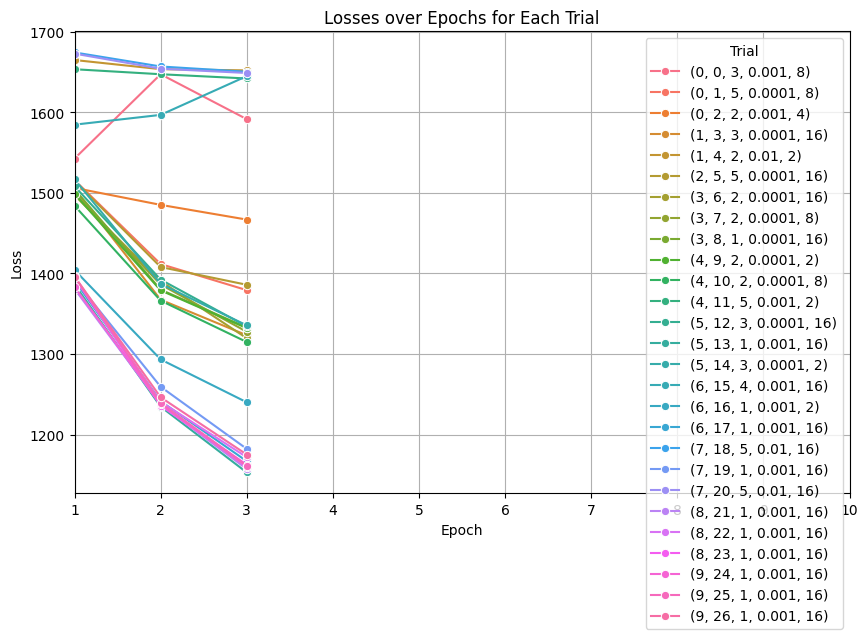

In [44]:
# Prepare data for plotting
plot_data = []
for trial_idx, trial_losses in losses.items():
    for epoch, loss_val in enumerate(trial_losses):
        plot_data.append({'Trial': trial_idx, 'Epoch': epoch + 1, 'Loss': loss_val})

df_losses = pd.DataFrame(plot_data)

# Plotting the losses
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Trial', marker='o')
plt.title('Losses over Epochs for Each Trial')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xlim(1, 10) # Set x-axis limit to 10 epochs
plt.show()

In [46]:
client.get_best_parameterization()

({'hidden_size': 5, 'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 16},
 {'loss': (np.float64(1164.0720341663332), np.float64(29.860397149047486))},
 13,
 '13_0')

In [51]:
(best_parameters, loss, _, _) = client.get_best_parameterization()

print("Best Hyperparameters:")
for key, value in best_parameters.items():
    print(f"  {key}: {value}")

Best Hyperparameters:
  hidden_size: 5
  num_layers: 1
  learning_rate: 0.001
  num_heads: 16


In [53]:
embedding_dim = 64
hidden_size = 20
num_layers = 1
output_size = 5
vocabulary_size = len(vocab)
learning_rate = 0.01

num_layers = best_parameters["num_layers"]
learning_rate = best_parameters["learning_rate"]
num_heads = best_parameters["num_heads"]

dataset = TextDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

model = SentimentTransformer(vocabulary_size, embedding_dim, num_heads, num_layers, output_size).to(device)
# Use BCEWithLogitsLoss to handle raw logits from the model
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (X, y) in enumerate(dataloader):
        # Truncate sequence length to max_len (512) to avoid position encoding mismatch
        if X.size(1) > 512:
            X = X[:, :512]

        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses[(i, trial_index, num_layers, learning_rate, num_heads)].append(total_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

print("Training completed.")

# Set raw_data as a dictionary with metric names as keys and results as values
raw_data = {metric_name: total_loss}

/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/10], Loss: 1384.5893
Epoch [2/10], Loss: 1239.6107
Epoch [3/10], Loss: 1167.1104
Epoch [4/10], Loss: 1100.0390
Epoch [5/10], Loss: 1040.6376
Epoch [6/10], Loss: 983.2575
Epoch [7/10], Loss: 930.3253
Epoch [8/10], Loss: 878.1902
Epoch [9/10], Loss: 834.3745
Epoch [10/10], Loss: 781.4071
Training completed.


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Create DataLoader for test data
test_dataset = TextDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X, y in test_dataloader:
        # Truncate sequence length to max_len (512) to match training
        if X.size(1) > 512:
            X = X[:, :512]

        X = X.to(device)
        outputs = model(X)

        # Get predicted class indices (argmax of logits)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Get true class indices from one-hot encoded labels
        targets = torch.argmax(y, dim=1).numpy()

        all_preds.extend(preds)
        all_targets.extend(targets)

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Accuracy: 0.6411
Precision: 0.6215
Recall: 0.6411


In [57]:
#Ax configuration
client = Client()
parameters = [
    RangeParameterConfig(
        name="num_layers", parameter_type="int", bounds=(1, 5)
    ),
    ChoiceParameterConfig(
        name="learning_rate",
        parameter_type="float",
        values=(0.0001, 0.001, 0.01),
        is_ordered=True
    ),

    ChoiceParameterConfig(
        name="num_heads", parameter_type="int", values=(2, 4, 8, 16),
        is_ordered=True
    )
]

client.configure_experiment(parameters=parameters)

metric_name = "loss"
client.configure_optimization(objective=f"-{metric_name}")

In [65]:
embedding_dim = 64
hidden_size = 20
num_layers = 1
output_size = 3
vocabulary_size = len(vocab)
learning_rate = 0.01

losses = defaultdict(list)

for i in range(10):
    trials = client.get_next_trials(max_trials=3)

    for trial_index, parameters in trials.items():
        # Note: hidden_size from parameters is currently ignored to ensure compatibility
        # with num_heads choices. We use fixed embedding_dim=64.
        # hidden_size = parameters["hidden_size"]
        num_layers = parameters["num_layers"]
        learning_rate = parameters["learning_rate"]
        num_heads = parameters["num_heads"]

        print("Hyperparameters: ", num_layers, learning_rate, num_heads)

        dataset = TextDataset(X_train3, y_train3)
        dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

        model = SentimentTransformer(len(vocab), embedding_dim, num_heads, num_layers, output_size).to(device)
        # Use BCEWithLogitsLoss to handle raw logits from the model
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        num_epochs = 3

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for batch_idx, (X, y) in enumerate(dataloader):
                # Truncate sequence length to max_len (512) to avoid position encoding mismatch
                if X.size(1) > 512:
                    X = X[:, :512]

                X = X.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                outputs = model(X)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            losses[(i, trial_index, embedding_dim, num_layers, learning_rate, num_heads)].append(total_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

        print("Training completed.")

        # Set raw_data as a dictionary with metric names as keys and results as values
        raw_data = {metric_name: total_loss}

        # Complete the trial with the result
        client.complete_trial(trial_index=trial_index, raw_data=raw_data)

[INFO 12-13 21:04:34] ax.api.client: Generated new trial 27 with parameters {'num_layers': 4, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-13 21:04:34] ax.api.client: Generated new trial 28 with parameters {'num_layers': 4, 'learning_rate': 0.0001, 'num_heads': 4} using GenerationNode MBM.
[INFO 12-13 21:04:34] ax.api.client: Generated new trial 29 with parameters {'num_layers': 5, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  4 0.0001 8
Epoch [1/3], Loss: 1580.9678
Epoch [2/3], Loss: 1452.0005


[INFO 12-13 21:07:08] ax.api.client: Trial 27 marked COMPLETED.


Epoch [3/3], Loss: 1401.7442
Training completed.
Hyperparameters:  4 0.0001 4


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1553.2066
Epoch [2/3], Loss: 1445.2072


[INFO 12-13 21:09:44] ax.api.client: Trial 28 marked COMPLETED.


Epoch [3/3], Loss: 1421.7240
Training completed.
Hyperparameters:  5 0.0001 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1578.6477
Epoch [2/3], Loss: 1482.2059


[INFO 12-13 21:12:54] ax.api.client: Trial 29 marked COMPLETED.


Epoch [3/3], Loss: 1471.6088
Training completed.


[INFO 12-13 21:12:55] ax.api.client: Generated new trial 30 with parameters {'num_layers': 4, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 21:12:55] ax.api.client: Generated new trial 31 with parameters {'num_layers': 3, 'learning_rate': 0.01, 'num_heads': 2} using GenerationNode MBM.
[INFO 12-13 21:12:55] ax.api.client: Generated new trial 32 with parameters {'num_layers': 4, 'learning_rate': 0.01, 'num_heads': 2} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  4 0.001 16
Epoch [1/3], Loss: 1810.6860
Epoch [2/3], Loss: 1802.9707


[INFO 12-13 21:15:29] ax.api.client: Trial 30 marked COMPLETED.


Epoch [3/3], Loss: 1797.7328
Training completed.
Hyperparameters:  3 0.01 2


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1832.8132
Epoch [2/3], Loss: 1812.9988


[INFO 12-13 21:17:32] ax.api.client: Trial 31 marked COMPLETED.


Epoch [3/3], Loss: 1803.5576
Training completed.
Hyperparameters:  4 0.01 2


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1826.9829
Epoch [2/3], Loss: 1808.6921


[INFO 12-13 21:20:05] ax.api.client: Trial 32 marked COMPLETED.


Epoch [3/3], Loss: 1804.7083
Training completed.


[INFO 12-13 21:20:05] ax.api.client: Generated new trial 33 with parameters {'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-13 21:20:05] ax.api.client: Generated new trial 34 with parameters {'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 4} using GenerationNode MBM.
[INFO 12-13 21:20:05] ax.api.client: Generated new trial 35 with parameters {'num_layers': 2, 'learning_rate': 0.001, 'num_heads': 2} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  3 0.0001 8
Epoch [1/3], Loss: 1540.0845
Epoch [2/3], Loss: 1378.7812


[INFO 12-13 21:22:07] ax.api.client: Trial 33 marked COMPLETED.


Epoch [3/3], Loss: 1308.1377
Training completed.
Hyperparameters:  3 0.0001 4


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1571.6293
Epoch [2/3], Loss: 1447.2809


[INFO 12-13 21:24:06] ax.api.client: Trial 34 marked COMPLETED.


Epoch [3/3], Loss: 1378.2714
Training completed.
Hyperparameters:  2 0.001 2


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1586.4779
Epoch [2/3], Loss: 1539.5315


[INFO 12-13 21:25:36] ax.api.client: Trial 35 marked COMPLETED.


Epoch [3/3], Loss: 1559.2953
Training completed.


[INFO 12-13 21:25:37] ax.api.client: Generated new trial 36 with parameters {'num_layers': 5, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-13 21:25:37] ax.api.client: Generated new trial 37 with parameters {'num_layers': 2, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 21:25:37] ax.api.client: Generated new trial 38 with parameters {'num_layers': 5, 'learning_rate': 0.0001, 'num_heads': 4} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  5 0.0001 8
Epoch [1/3], Loss: 1604.5934
Epoch [2/3], Loss: 1503.6559


[INFO 12-13 21:28:42] ax.api.client: Trial 36 marked COMPLETED.


Epoch [3/3], Loss: 1481.2329
Training completed.
Hyperparameters:  2 0.001 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1552.6361
Epoch [2/3], Loss: 1493.2248


[INFO 12-13 21:30:11] ax.api.client: Trial 37 marked COMPLETED.


Epoch [3/3], Loss: 1467.8076
Training completed.
Hyperparameters:  5 0.0001 4


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1576.7178
Epoch [2/3], Loss: 1459.9981


[INFO 12-13 21:33:17] ax.api.client: Trial 38 marked COMPLETED.


Epoch [3/3], Loss: 1435.0697
Training completed.


[INFO 12-13 21:33:17] ax.api.client: Generated new trial 39 with parameters {'num_layers': 2, 'learning_rate': 0.001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-13 21:33:17] ax.api.client: Generated new trial 40 with parameters {'num_layers': 2, 'learning_rate': 0.01, 'num_heads': 2} using GenerationNode MBM.
[INFO 12-13 21:33:17] ax.api.client: Generated new trial 41 with parameters {'num_layers': 2, 'learning_rate': 0.01, 'num_heads': 8} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  2 0.001 8
Epoch [1/3], Loss: 1501.6203
Epoch [2/3], Loss: 1501.0899


[INFO 12-13 21:34:47] ax.api.client: Trial 39 marked COMPLETED.


Epoch [3/3], Loss: 1486.6241
Training completed.
Hyperparameters:  2 0.01 2


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1831.4597
Epoch [2/3], Loss: 1809.8458


[INFO 12-13 21:36:16] ax.api.client: Trial 40 marked COMPLETED.


Epoch [3/3], Loss: 1804.4627
Training completed.
Hyperparameters:  2 0.01 8


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1833.1155
Epoch [2/3], Loss: 1807.9813


[INFO 12-13 21:37:47] ax.api.client: Trial 41 marked COMPLETED.


Epoch [3/3], Loss: 1801.8008
Training completed.


[INFO 12-13 21:37:47] ax.api.client: Generated new trial 42 with parameters {'num_layers': 3, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 21:37:47] ax.api.client: Generated new trial 43 with parameters {'num_layers': 5, 'learning_rate': 0.01, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-13 21:37:47] ax.api.client: Generated new trial 44 with parameters {'num_layers': 3, 'learning_rate': 0.001, 'num_heads': 2} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  3 0.001 16
Epoch [1/3], Loss: 1661.3757
Epoch [2/3], Loss: 1656.0550


[INFO 12-13 21:39:49] ax.api.client: Trial 42 marked COMPLETED.


Epoch [3/3], Loss: 1797.4046
Training completed.
Hyperparameters:  5 0.01 16


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1833.0534
Epoch [2/3], Loss: 1806.1410


[INFO 12-13 21:42:59] ax.api.client: Trial 43 marked COMPLETED.


Epoch [3/3], Loss: 1804.4736
Training completed.
Hyperparameters:  3 0.001 2


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1594.9671
Epoch [2/3], Loss: 1561.2750


[INFO 12-13 21:45:04] ax.api.client: Trial 44 marked COMPLETED.
[INFO 12-13 21:45:04] ax.api.client: Generated new trial 45 with parameters {'num_layers': 3, 'learning_rate': 0.001, 'num_heads': 4} using GenerationNode MBM.
[INFO 12-13 21:45:04] ax.api.client: Generated new trial 46 with parameters {'num_layers': 4, 'learning_rate': 0.001, 'num_heads': 2} using GenerationNode MBM.
[INFO 12-13 21:45:04] ax.api.client: Generated new trial 47 with parameters {'num_layers': 5, 'learning_rate': 0.001, 'num_heads': 2} using GenerationNode MBM.


Epoch [3/3], Loss: 1592.6291
Training completed.
Hyperparameters:  3 0.001 4


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1633.8752
Epoch [2/3], Loss: 1759.0581


[INFO 12-13 21:47:09] ax.api.client: Trial 45 marked COMPLETED.


Epoch [3/3], Loss: 1797.6084
Training completed.
Hyperparameters:  4 0.001 2


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1806.9807
Epoch [2/3], Loss: 1798.7524


[INFO 12-13 21:49:46] ax.api.client: Trial 46 marked COMPLETED.


Epoch [3/3], Loss: 1797.6453
Training completed.
Hyperparameters:  5 0.001 2


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1808.6174
Epoch [2/3], Loss: 1801.2041


[INFO 12-13 21:53:01] ax.api.client: Trial 47 marked COMPLETED.


Epoch [3/3], Loss: 1798.4085
Training completed.


[INFO 12-13 21:53:02] ax.api.client: Generated new trial 48 with parameters {'num_layers': 4, 'learning_rate': 0.001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-13 21:53:02] ax.api.client: Generated new trial 49 with parameters {'num_layers': 2, 'learning_rate': 0.01, 'num_heads': 4} using GenerationNode MBM.
[INFO 12-13 21:53:02] ax.api.client: Generated new trial 50 with parameters {'num_layers': 4, 'learning_rate': 0.001, 'num_heads': 4} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  4 0.001 8


/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1810.2264
Epoch [2/3], Loss: 1799.6587


[INFO 12-13 21:55:38] ax.api.client: Trial 48 marked COMPLETED.


Epoch [3/3], Loss: 1798.2954
Training completed.
Hyperparameters:  2 0.01 4


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1836.4365
Epoch [2/3], Loss: 1809.6969


[INFO 12-13 21:57:09] ax.api.client: Trial 49 marked COMPLETED.


Epoch [3/3], Loss: 1802.8507
Training completed.
Hyperparameters:  4 0.001 4


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1808.4817
Epoch [2/3], Loss: 1799.2862


[INFO 12-13 21:59:43] ax.api.client: Trial 50 marked COMPLETED.


Epoch [3/3], Loss: 1801.1693
Training completed.


[INFO 12-13 21:59:43] ax.api.client: Generated new trial 51 with parameters {'num_layers': 5, 'learning_rate': 0.001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-13 21:59:43] ax.api.client: Generated new trial 52 with parameters {'num_layers': 5, 'learning_rate': 0.01, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-13 21:59:43] ax.api.client: Generated new trial 53 with parameters {'num_layers': 5, 'learning_rate': 0.01, 'num_heads': 4} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  5 0.001 8
Epoch [1/3], Loss: 1808.1975
Epoch [2/3], Loss: 1803.7620


[INFO 12-13 22:02:51] ax.api.client: Trial 51 marked COMPLETED.


Epoch [3/3], Loss: 1800.7041
Training completed.
Hyperparameters:  5 0.01 8


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1832.3952
Epoch [2/3], Loss: 1807.8650


[INFO 12-13 22:06:01] ax.api.client: Trial 52 marked COMPLETED.


Epoch [3/3], Loss: 1802.3663
Training completed.
Hyperparameters:  5 0.01 4


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1830.9189
Epoch [2/3], Loss: 1810.7288


[INFO 12-13 22:09:10] ax.api.client: Trial 53 marked COMPLETED.


Epoch [3/3], Loss: 1802.7033
Training completed.


[INFO 12-13 22:09:10] ax.api.client: Generated new trial 54 with parameters {'num_layers': 5, 'learning_rate': 0.001, 'num_heads': 4} using GenerationNode MBM.
[INFO 12-13 22:09:10] ax.api.client: Generated new trial 55 with parameters {'num_layers': 4, 'learning_rate': 0.01, 'num_heads': 4} using GenerationNode MBM.
[INFO 12-13 22:09:10] ax.api.client: Generated new trial 56 with parameters {'num_layers': 4, 'learning_rate': 0.01, 'num_heads': 8} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  5 0.001 4
Epoch [1/3], Loss: 1804.7022
Epoch [2/3], Loss: 1799.3846


[INFO 12-13 22:12:18] ax.api.client: Trial 54 marked COMPLETED.


Epoch [3/3], Loss: 1798.0288
Training completed.
Hyperparameters:  4 0.01 4


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1830.5736
Epoch [2/3], Loss: 1813.8602


[INFO 12-13 22:14:53] ax.api.client: Trial 55 marked COMPLETED.


Epoch [3/3], Loss: 1803.9408
Training completed.
Hyperparameters:  4 0.01 8


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1835.5624
Epoch [2/3], Loss: 1811.1531


[INFO 12-13 22:17:29] ax.api.client: Trial 56 marked COMPLETED.


Epoch [3/3], Loss: 1802.9044
Training completed.


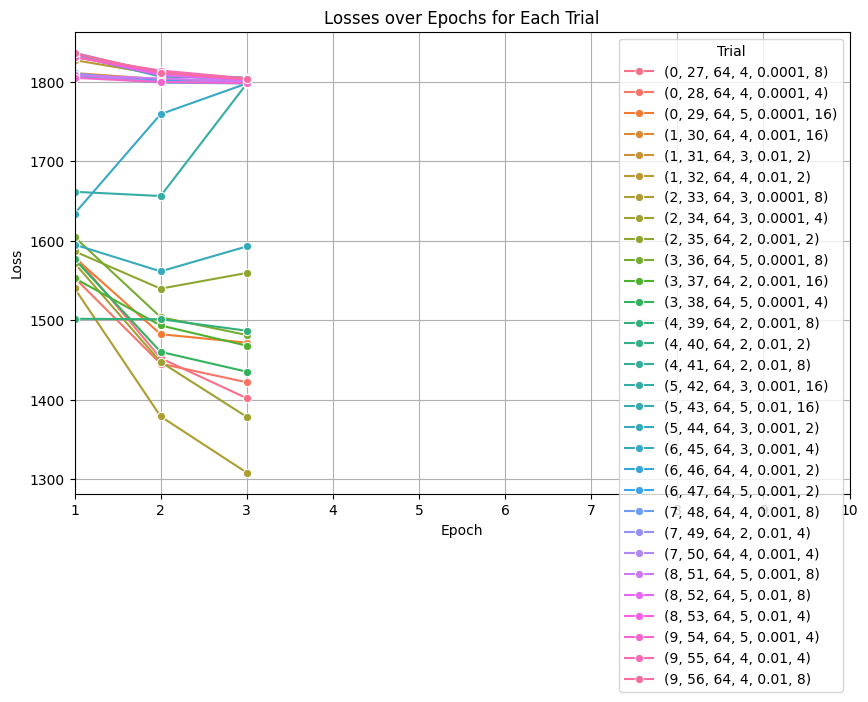

In [66]:
# Prepare data for plotting
plot_data = []
for trial_idx, trial_losses in losses.items():
    for epoch, loss_val in enumerate(trial_losses):
        plot_data.append({'Trial': trial_idx, 'Epoch': epoch + 1, 'Loss': loss_val})

df_losses = pd.DataFrame(plot_data)

# Plotting the losses
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Trial', marker='o')
plt.title('Losses over Epochs for Each Trial')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xlim(1, 10) # Set x-axis limit to 10 epochs
plt.show()

In [67]:
(best_parameters, loss, _, _) = client.get_best_parameterization()

print("Best Hyperparameters:")
for key, value in best_parameters.items():
    print(f"  {key}: {value}")

Best Hyperparameters:
  num_layers: 1
  learning_rate: 0.001
  num_heads: 16


In [68]:
embedding_dim = 64
hidden_size = 20
num_layers = 1
output_size = 3
vocabulary_size = len(vocab)
learning_rate = 0.01

num_layers = best_parameters["num_layers"]
learning_rate = best_parameters["learning_rate"]
num_heads = best_parameters["num_heads"]

dataset = TextDataset(X_train3, y_train3)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

model = SentimentTransformer(vocabulary_size, embedding_dim, num_heads, num_layers, output_size).to(device)
# Use BCEWithLogitsLoss to handle raw logits from the model
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (X, y) in enumerate(dataloader):
        # Truncate sequence length to max_len (512) to avoid position encoding mismatch
        if X.size(1) > 512:
            X = X[:, :512]

        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses[(i, trial_index, embedding_dim, num_layers, learning_rate, num_heads)].append(total_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

print("Training completed.")

# Set raw_data as a dictionary with metric names as keys and results as values
raw_data = {metric_name: total_loss}

/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/10], Loss: 1425.4466
Epoch [2/10], Loss: 1196.2730
Epoch [3/10], Loss: 1072.9412
Epoch [4/10], Loss: 967.0585
Epoch [5/10], Loss: 893.3896
Epoch [6/10], Loss: 819.2842
Epoch [7/10], Loss: 729.8619
Epoch [8/10], Loss: 665.7562
Epoch [9/10], Loss: 605.1421
Epoch [10/10], Loss: 508.3807
Training completed.


In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Re-generate the split to ensure X_test3 and y_test3 are fresh and aligned
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    encoded, satisfied_3labels, test_size=0.2, random_state=42
)

# Create DataLoader for test data
test_dataset = TextDataset(X_test3, y_test3)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X, y in test_dataloader:
        # Truncate sequence length to max_len (512) to match training
        if X.size(1) > 512:
            X = X[:, :512]

        X = X.to(device)
        outputs = model(X)

        # Get predicted class indices (argmax of logits)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Get true class indices from one-hot encoded labels
        targets = torch.argmax(y, dim=1).numpy()

        all_preds.extend(preds)
        all_targets.extend(targets)

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Accuracy: 0.8084
Precision: 0.7691
Recall: 0.8084
